In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from joblib import dump
from sklearn.pipeline import Pipeline
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

Importando DF para limitarlo a cosas de niquel

In [2]:
csv_path = 'cleanData.csv'
df = pd.read_csv(csv_path)

In [3]:
# Filtrar el DataFrame para quedarse solo con las filas donde 'Elemento' es 'Ni'
cleanDF = df[df['Elemento'] == 'Ni']

# Eliminar la columna 'Elemento'
cleanDF.drop(columns='Elemento', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_32636\984873699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanDF.drop(columns='Elemento', inplace=True)


In [4]:
cleanDF

,Ecut,KPoints,Pseudopotencial,Total Energy (Ry)
4763,15,1 1 1,Ni.pbesol-spn-kjpaw_psl.1.0.0,-351.476648
4764,15,1 1 1,Ni.pbesol-spn-rrkjus_psl.1.0.0,-266.675448
4765,15,1 1 1,Ni.pbe-spn-kjpaw_psl.1.0.0,-353.742357
4766,15,1 1 1,Ni.pbe-spn-rrkjus_psl.1.0.0,-266.530727
4767,15,2 2 2,Ni.pbesol-spn-kjpaw_psl.1.0.0,-354.727505
...,...,...,...,...
5550,100,10 10 10,Ni.pbe-spn-rrkjus_psl.1.0.0,-339.605964
5551,100,11 11 11,Ni.pbesol-spn-kjpaw_psl.1.0.0,-426.577757
5552,100,11 11 11,Ni.pbesol-spn-rrkjus_psl.1.0.0,-339.401119
5553,100,11 11 11,Ni.pbe-spn-kjpaw_psl.1.0.0,-429.158339


No se logró un buen desempeño de la red, lo limitaremos a un pseudopotencial

In [5]:
# Supongamos que cleanDF es tu DataFrame original
unique_pseudopotentials = cleanDF['Pseudopotencial'].unique()  # Encuentra todos los valores únicos en la columna 'pseudopotencial'

dataframes = {}  # Un diccionario para almacenar cada DataFrame

for pseudopotential in unique_pseudopotentials:
    # Crear un nuevo DataFrame filtrado para cada pseudopotencial
    df_temp = cleanDF[cleanDF['Pseudopotencial'] == pseudopotential]
    
    # Eliminar la columna 'pseudopotencial'
    df_temp = df_temp.drop(columns='Pseudopotencial')
    
    # Guardar el DataFrame en el diccionario
    dataframes[pseudopotential] = df_temp

tenemos un diccionario con todos los dataframes SIN pseudopotencial 

In [100]:
# Selecting the numerical and categorical columns
numerical_cols = ['Ecut']  # the numerical column
categorical_cols = dataframes['Ni.pbe-spn-kjpaw_psl.1.0.0'].columns.drop(['Ecut', 'Total Energy (Ry)'])  # all   other columns are categorical

In [101]:
# Creating transformers for the numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [102]:
# Creating a preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [103]:
# Re-setup preprocessing and transformation
# Assume preprocessor is already defined and includes scaling for 'ecut' and one-hot encoding for categorical columns
X = dataframes['Ni.pbe-spn-kjpaw_psl.1.0.0'].drop('Total Energy (Ry)', axis=1)
y = dataframes['Ni.pbe-spn-kjpaw_psl.1.0.0']['Total Energy (Ry)']

In [104]:
X_transformed = preprocessor.fit_transform(X)  # Re-fit the preprocessor

In [105]:
# Create a preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

In [107]:
# Convert data types to float32 for neural network processing
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [108]:
# Model configuration
input_dim = X_train.shape[1]  # Number of features
print(f'Columnas de input: {input_dim}')

Columnas de input: 12


In [109]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),  # First hidden layer
    Dense(64, activation='relu'), 
    Dense(1, activation='linear')  # Output layer
])

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [110]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [111]:
# Training the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.5, verbose=0)

In [115]:
# Assuming history is returned by model.fit
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

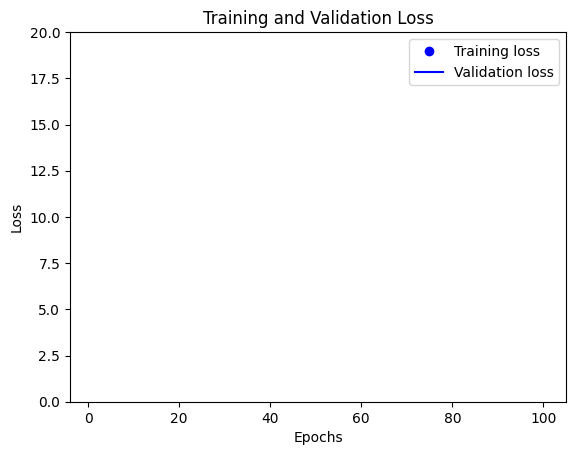

In [116]:
# Plotting the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')  # 'bo' gives us blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 'b' gives us a solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 20)
plt.legend()
plt.show()

In [114]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print the metrics
print(f'R-squared (R2): {r2:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.6f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
R-squared (R2): -3.14
Mean Squared Error (MSE): 1116.29
Mean Absolute Error (MAE): 29.203709
Root Mean Squared Error (RMSE): 33.41
